In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_log_error as rmsle
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import KFold
import lightgbm as lgb
import seaborn as sns
import itertools

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [3]:
y = np.log1p(train['Calories'])

X = train.drop(columns=['id', 'Calories'])
X['Sex'] = X['Sex'].astype('category')

X['BMI'] = X['Weight']/((X['Height']/100)**2)
X['Duration_x_Heart_Rate'] = X['Duration']*X['Heart_Rate']
X['Duration_x_Body_Temp'] = X['Duration']*X['Body_Temp']
X['Heart_Rate_x_Body_Temp'] = X['Heart_Rate']*X['Body_Temp']
X['Age_x_Heart_Rate'] = X['Age']*X['Heart_Rate']

X.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp,Age_x_Heart_Rate
0,male,36,189.0,82.0,26.0,101.0,41.0,22.955684,2626.0,1066.0,4141.0,3636.0
1,female,64,163.0,60.0,8.0,85.0,39.7,22.582709,680.0,317.6,3374.5,5440.0
2,female,51,161.0,64.0,7.0,84.0,39.8,24.690405,588.0,278.6,3343.2,4284.0
3,male,20,192.0,90.0,25.0,105.0,40.7,24.414062,2625.0,1017.5,4273.5,2100.0
4,female,38,166.0,61.0,25.0,102.0,40.6,22.136740,2550.0,1015.0,4141.2,3876.0


In [4]:
y.describe()

count    750000.000000
mean          4.141144
std           0.963231
min           0.693147
25%           3.555348
50%           4.356709
75%           4.919981
max           5.752573
Name: Calories, dtype: float64

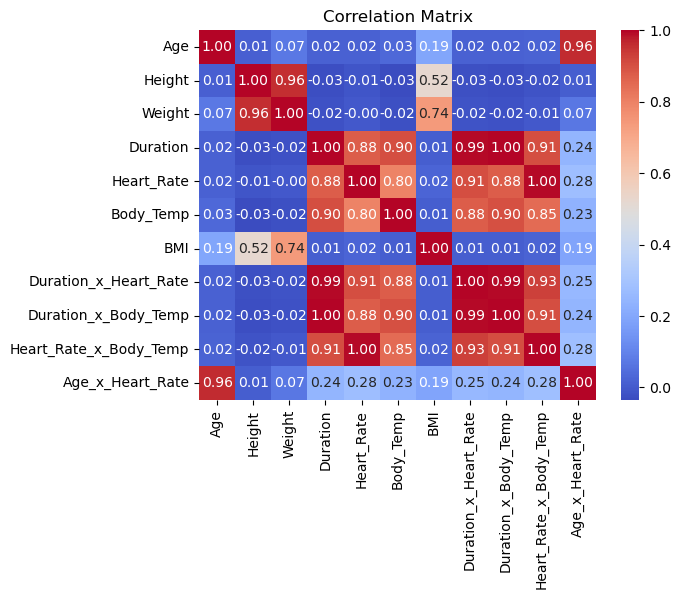

In [8]:
noncat = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI', 'Duration_x_Heart_Rate', 'Duration_x_Body_Temp', 'Heart_Rate_x_Body_Temp', 'Age_x_Heart_Rate']

sns.heatmap(X[noncat].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [21]:
number_leaves = [100, 150, 200, 250]
learning_rate = [0.1, 0.05]
number_boosts = [100,150,200]
subsamp = [0.8, 0.9, 1]

model_err = {}

for nl, lr, nbr, ss in itertools.product(number_leaves, learning_rate, number_boosts, subsamp):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True)

    # Initialize a list to collect accuracy scores
    scores = []

    # Iterate over each fold
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        dtrain = lgb.Dataset(X_train, label=y_train)
                
        # Define parameters
        params = {
            'num_leaves': nl,
            'learning_rate': lr,
            'objective': 'regression',  # same as rmse
            'metric': 'rmse',           # 
            'force_col_wise': True,     # Optional: can help with categorical support
            'subsample': ss,
            'class_weight': 'balanced',
            'verbose': -1
        }

        # Initialize and train the model
        model = lgb.train(params, dtrain, num_boost_round=nbr, valid_sets=lgb.Dataset(X_test, label=y_test), callbacks=[lgb.early_stopping(stopping_rounds=5)])


        # Predict and evaluate the model
        y_pred = model.predict(X_test)
        y_pred[y_pred <= 0] = 1
        score = rmse(y_test, y_pred)
        scores.append(score)

            
    # Output the mean accuracy over all folds
    # print(f"Mean Accuracy for num_leaves={nl}, learn_rate={lr}, num_boost={nbr}, subsample={ss}: {np.mean(scores)}")

    model_err[f"num_leaves_{nl}_learn_rate_{lr}_num_boost_{nbr}_subsample_{ss}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.0601241
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.0616316
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 0.0611812
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.0601983
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[92]	valid_0's rmse: 0.0609058
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.0606134
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.0609047
Training until validation scores do

In [23]:
number_leaves = [275, 300, 325]
learning_rate = [0.05]
number_boosts = [200, 250, 300]
subsamp = [0.9]

model_err = {}

for nl, lr, nbr, ss in itertools.product(number_leaves, learning_rate, number_boosts, subsamp):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True)

    # Initialize a list to collect accuracy scores
    scores = []

    # Iterate over each fold
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        dtrain = lgb.Dataset(X_train, label=y_train)
                
        # Define parameters
        params = {
            'num_leaves': nl,
            'learning_rate': lr,
            'objective': 'regression',  # same as rmse
            'metric': 'rmse',           # 
            'force_col_wise': True,     # Optional: can help with categorical support
            'subsample': ss,
            'class_weight': 'balanced',
            'verbose': -1
        }

        # Initialize and train the model
        model = lgb.train(params, dtrain, num_boost_round=nbr, valid_sets=lgb.Dataset(X_test, label=y_test), callbacks=[lgb.early_stopping(stopping_rounds=5, verbose=False)])


        # Predict and evaluate the model
        y_pred = model.predict(X_test)
        y_pred[y_pred <= 0] = 1
        score = rmse(y_test, y_pred)
        scores.append(score)

            
    # Output the mean accuracy over all folds
    print(f"Mean Accuracy for num_leaves={nl}, learn_rate={lr}, num_boost={nbr}, subsample={ss}: {np.mean(scores)}")

    model_err[f"num_leaves_{nl}_learn_rate_{lr}_num_boost_{nbr}_subsample_{ss}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for num_leaves=275, learn_rate=0.05, num_boost=200, subsample=0.9: 0.060275653688296515
Mean Accuracy for num_leaves=275, learn_rate=0.05, num_boost=250, subsample=0.9: 0.06017420556092111
Mean Accuracy for num_leaves=275, learn_rate=0.05, num_boost=300, subsample=0.9: 0.06029355293980045
Mean Accuracy for num_leaves=300, learn_rate=0.05, num_boost=200, subsample=0.9: 0.060196910009760705
Mean Accuracy for num_leaves=300, learn_rate=0.05, num_boost=250, subsample=0.9: 0.06012901691728926
Mean Accuracy for num_leaves=300, learn_rate=0.05, num_boost=300, subsample=0.9: 0.06017091044943692
Mean Accuracy for num_leaves=325, learn_rate=0.05, num_boost=200, subsample=0.9: 0.06017668358506789
Mean Accuracy for num_leaves=325, learn_rate=0.05, num_boost=250, subsample=0.9: 0.060221056899611804
Mean Accuracy for num_leaves=325, learn_rate=0.05, num_boost=300, subsample=0.9: 0.06020431284266662
The key with the minimum value is 'num_leaves_300_learn_rate_0.05_num_boost_250_subsampl

In [5]:
number_leaves = [250, 300]
learning_rate = [0.7, 0.05, 0.03]
number_boosts = [225, 250, 275]
subsamp = [0.8, 0.9, 1]

model_err = {}

for nl, lr, nbr, ss in itertools.product(number_leaves, learning_rate, number_boosts, subsamp):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True)

    # Initialize a list to collect accuracy scores
    scores = []

    # Iterate over each fold
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        dtrain = lgb.Dataset(X_train, label=y_train)
                
        # Define parameters
        params = {
            'num_leaves': nl,
            'learning_rate': lr,
            'objective': 'regression',  # same as rmse
            'metric': 'rmse',           # 
            'force_col_wise': True,     # Optional: can help with categorical support
            'subsample': ss,
            'verbose': -1
        }

        # Initialize and train the model
        model = lgb.train(params, dtrain, num_boost_round=nbr)


        # Predict and evaluate the model
        y_pred = model.predict(X_test)
        y_pred[y_pred <= 0] = 1
        score = rmse(y_test, y_pred)
        scores.append(score)

            
    # Output the mean accuracy over all folds
    print(f"Mean Accuracy for num_leaves={nl}, learn_rate={lr}, num_boost={nbr}, subsample={ss}: {np.mean(scores)}")

    model_err[f"num_leaves_{nl}_learn_rate_{lr}_num_boost_{nbr}_subsample_{ss}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for num_leaves=250, learn_rate=0.7, num_boost=225, subsample=0.8: 0.06912050063318823
Mean Accuracy for num_leaves=250, learn_rate=0.7, num_boost=225, subsample=0.9: 0.06915827255519956
Mean Accuracy for num_leaves=250, learn_rate=0.7, num_boost=225, subsample=1: 0.06898978687361118
Mean Accuracy for num_leaves=250, learn_rate=0.7, num_boost=250, subsample=0.8: 0.06921358240231518
Mean Accuracy for num_leaves=250, learn_rate=0.7, num_boost=250, subsample=0.9: 0.06948632605722223
Mean Accuracy for num_leaves=250, learn_rate=0.7, num_boost=250, subsample=1: 0.06949986463431086
Mean Accuracy for num_leaves=250, learn_rate=0.7, num_boost=275, subsample=0.8: 0.0696359114601323
Mean Accuracy for num_leaves=250, learn_rate=0.7, num_boost=275, subsample=0.9: 0.0697517976563993
Mean Accuracy for num_leaves=250, learn_rate=0.7, num_boost=275, subsample=1: 0.06983976363056109
Mean Accuracy for num_leaves=250, learn_rate=0.05, num_boost=225, subsample=0.8: 0.06011203916421556
Mean Ac

In [ ]:
number_leaves = [125, 150, 175, 200, 225, 250]
learning_rate = [0.1, 0.05, 0.03]
number_boosts = [100,150,200]

model_err = {}

for nl in number_leaves:
    for lr in learning_rate:
        for nbr in number_boosts:

            # Initialize KFold
            kf = KFold(n_splits=5, shuffle=True)

            # Initialize a list to collect accuracy scores
            scores = []

            # Iterate over each fold
            for train_index, test_index in kf.split(X):

                X_train, X_test = X.loc[train_index], X.loc[test_index]
                y_train, y_test = y.loc[train_index], y.loc[test_index]

                dtrain = lgb.Dataset(X_train, label=y_train)

                
                # Define parameters
                params = {
                    'num_leaves': nl,
                    'learning_rate': lr,
                    'objective': 'regression',  # same as rmse
                    'metric': 'rmse',           # 
                    'force_col_wise': True,     # Optional: can help with categorical support
                    'subsample': 0.75,
                    'verbose': -1
                }

                # Initialize and train the model
                model = lgb.train(params, dtrain, num_boost_round=nbr)


                # Predict and evaluate the model
                y_pred = model.predict(X_test)
                y_pred[y_pred <= 0] = 1
                score = rmse(y_test, y_pred)
                scores.append(score)

            
            # Output the mean accuracy over all folds
            print(f"Mean Accuracy for num_leaves={nl}, learn_rate={lr}, num_boost={nbr}: {np.mean(scores)}")

            model_err[f"num_leaves_{nl}_learn_rate_{lr}_num_boost_{nbr}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for num_leaves=125, learn_rate=0.1, num_boost=100: 0.06055366841578187
Mean Accuracy for num_leaves=125, learn_rate=0.1, num_boost=150: 0.06049433216671289
Mean Accuracy for num_leaves=125, learn_rate=0.1, num_boost=200: 0.060601949670545975
Mean Accuracy for num_leaves=125, learn_rate=0.05, num_boost=100: 0.06165837304792178
Mean Accuracy for num_leaves=125, learn_rate=0.05, num_boost=150: 0.06052907552060518
Mean Accuracy for num_leaves=125, learn_rate=0.05, num_boost=200: 0.060327454676243675
Mean Accuracy for num_leaves=125, learn_rate=0.03, num_boost=100: 0.08039848150523946
Mean Accuracy for num_leaves=125, learn_rate=0.03, num_boost=150: 0.06262914239923197
Mean Accuracy for num_leaves=125, learn_rate=0.03, num_boost=200: 0.060829189731195
Mean Accuracy for num_leaves=150, learn_rate=0.1, num_boost=100: 0.060557608767404125
Mean Accuracy for num_leaves=150, learn_rate=0.1, num_boost=150: 0.06037838547011121
Mean Accuracy for num_leaves=150, learn_rate=0.1, num_boos

In [8]:
number_leaves = [200]
learning_rate = [0.04, 0.05, 0.06]
number_boosts = [200,225,250,275,300,400]

model_err = {}

for nl in number_leaves:
    for lr in learning_rate:
        for nbr in number_boosts:

            # Initialize KFold
            kf = KFold(n_splits=5, shuffle=True)

            # Initialize a list to collect accuracy scores
            scores = []

            # Iterate over each fold
            for train_index, test_index in kf.split(X):

                X_train, X_test = X.loc[train_index], X.loc[test_index]
                y_train, y_test = y.loc[train_index], y.loc[test_index]

                dtrain = lgb.Dataset(X_train, label=y_train)

                
                # Define parameters
                params = {
                    'num_leaves': nl,
                    'learning_rate': lr,
                    'objective': 'regression',  # LightGBM doesn't have squaredlogerror directly
                    'metric': 'rmse',           # 
                    'force_col_wise': True,     # Optional: can help with categorical support
                    'subsample': 0.75,
                    'verbose': -1
                }

                # Initialize and train the model
                model = lgb.train(params, dtrain, num_boost_round=nbr)


                # Predict and evaluate the model
                y_pred = model.predict(X_test)
                y_pred[y_pred <= 0] = 1
                score = rmse(y_test, y_pred)
                scores.append(score)

            
            # Output the mean accuracy over all folds
            print(f"Mean Accuracy for num_leaves={nl}, learn_rate={lr}, num_boost={nbr}: {np.mean(scores)}")

            model_err[f"num_leaves_{nl}_learn_rate_{lr}_num_boost_{nbr}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for num_leaves=200, learn_rate=0.04, num_boost=200: 0.06013460808149991
Mean Accuracy for num_leaves=200, learn_rate=0.04, num_boost=225: 0.0601566309983753
Mean Accuracy for num_leaves=200, learn_rate=0.04, num_boost=250: 0.060162501799494394
Mean Accuracy for num_leaves=200, learn_rate=0.04, num_boost=275: 0.060109162294593045
Mean Accuracy for num_leaves=200, learn_rate=0.04, num_boost=300: 0.060054874935611624
Mean Accuracy for num_leaves=200, learn_rate=0.04, num_boost=400: 0.06029916414396545
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=200: 0.06022580767089778
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=225: 0.06019983675687653
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=250: 0.06022313187773074
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=275: 0.0602439389235954
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=300: 0.06011566375334837
Mean Accuracy for num_leaves=200, learn_rate=0.05, nu

In [ ]:
number_leaves = [200]
learning_rate = [0.04]
number_boosts = [100,150,200,250,300,350]

model_err = {}

for nl in number_leaves:
    for lr in learning_rate:
        for nbr in number_boosts:

            # Initialize KFold
            kf = KFold(n_splits=5, shuffle=True)

            # Initialize a list to collect accuracy scores
            scores = []

            # Iterate over each fold
            for train_index, test_index in kf.split(X):

                X_train, X_test = X.loc[train_index], X.loc[test_index]
                y_train, y_test = y.loc[train_index], y.loc[test_index]

                dtrain = lgb.Dataset(X_train, label=y_train)

                
                # Define parameters
                params = {
                    'num_leaves': nl,
                    'learning_rate': lr,
                    'objective': 'regression',  # LightGBM doesn't have squaredlogerror directly
                    'metric': 'rmse',           # 
                    'force_col_wise': True,     # Optional: can help with categorical support
                    'subsample': 0.7,
                    'verbose': -1,
                    #'device': 'cuda'
                }

                # Initialize and train the model
                model = lgb.train(params, dtrain, num_boost_round=nbr)


                # Predict and evaluate the model
                y_pred = model.predict(X_test)
                y_pred[y_pred <= 0] = 10
                score = rmse(y_test, y_pred)
                scores.append(score)

            
            # Output the mean accuracy over all folds
            print(f"Mean Accuracy for num_leaves={nl}, learn_rate={lr}, num_boost={nbr}: {np.mean(scores)}")

            model_err[f"num_leaves_{nl}_learn_rate_{lr}_num_boost_{nbr}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

LightGBMError: CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1

In [6]:
X_train = train.sample(n=600000, random_state=212)
y_train = np.log1p(X_train['Calories'])

X_train.drop(columns=['id', 'Calories'], inplace=True)
X_train['Sex'] = X_train['Sex'].astype('category')

X_train['BMI'] = X_train['Weight']/((X_train['Height']/100)**2)
X_train['Duration_x_Heart_Rate'] = X_train['Duration']*X_train['Heart_Rate']
X_train['Duration_x_Body_Temp'] = X_train['Duration']*X_train['Body_Temp']
X_train['Heart_Rate_x_Body_Temp'] = X_train['Heart_Rate']*X_train['Body_Temp']
X_train['Age_x_Heart_Rate'] = X_train['Age']*X_train['Heart_Rate']

X_train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp,Age_x_Heart_Rate
637285,male,40,182.0,85.0,16.0,91.0,40.2,25.661152,1456.0,643.2,3658.2,3640.0
137087,female,30,158.0,64.0,10.0,90.0,40.2,25.636917,900.0,402.0,3618.0,2700.0
11662,male,54,184.0,87.0,3.0,82.0,38.8,25.697070,246.0,116.4,3181.6,4428.0
83022,female,61,186.0,81.0,25.0,106.0,40.7,23.413111,2650.0,1017.5,4314.2,6466.0
405249,female,40,169.0,69.0,11.0,99.0,39.9,24.158818,1089.0,438.9,3950.1,3960.0


0.05246269203674384


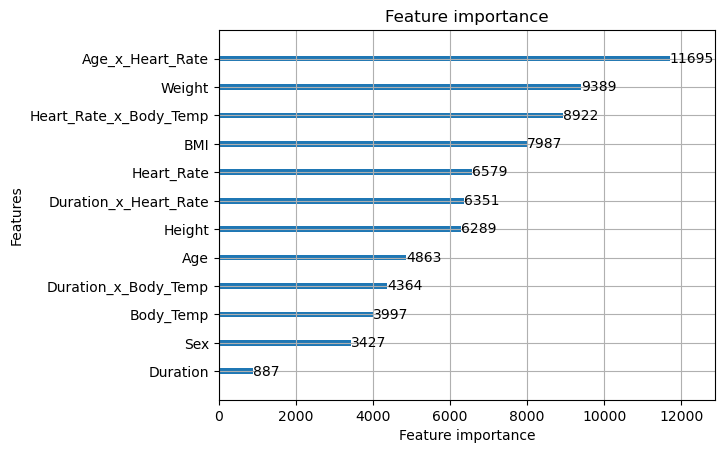

In [ ]:
# Kaggle score 0.05808, lgb_prediction_18.csv

dtrain = lgb.Dataset(X_train, label=y_train)

# Define parameters
params = {
    'num_leaves': 300,
    'learning_rate': 0.05,
    'objective': 'regression',  # LightGBM doesn't have squaredlogerror directly
    'metric': 'rmse',           # We'll manually compute RMSLE
    'force_col_wise': True,     # Optional: can help with categorical support
    'class_weight': 'balanced',
    'subsample': 0.9
}

# Train the model
model = lgb.train(params, dtrain, num_boost_round=250)

# Make predictions
test_pred = model.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
test_pred[test_pred < 0] = 1

print(rmse(test_pred, y_train))

lgb.plot_importance(model)
plt.show()

0.05342383456628782


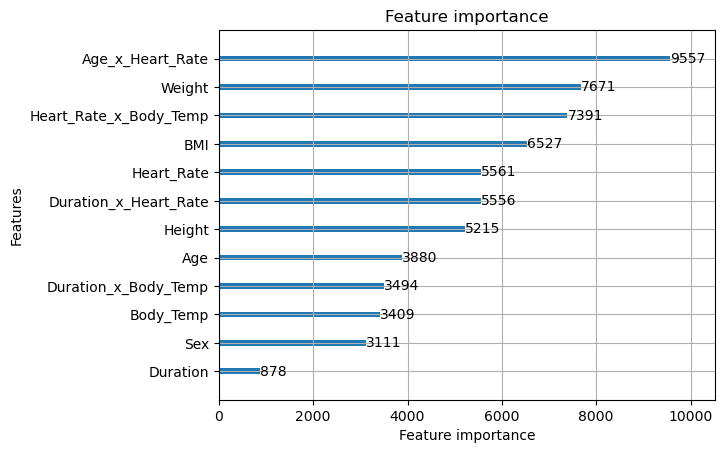

In [13]:
# Kaggle score 0.05792, lgb_prediction_15.csv

dtrain = lgb.Dataset(X_train, label=y_train)

# Define parameters
params = {
    'num_leaves': 250,
    'learning_rate': 0.05,
    'objective': 'regression',  # LightGBM doesn't have squaredlogerror directly
    'metric': 'rmse',           # We'll manually compute RMSLE
    'force_col_wise': True,     # Optional: can help with categorical support
    'subsample': 0.9
}

# Train the model
model = lgb.train(params, dtrain, num_boost_round=250)

# Make predictions
test_pred = model.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
test_pred[test_pred < 0] = 1

print(rmse(test_pred, y_train))

lgb.plot_importance(model)
plt.show()

In [ ]:
# Kaggle score 0.05799, lgb_prediction_13.csv

dtrain = lgb.Dataset(X_train, label=y_train)

# Define parameters
params = {
    'num_leaves': 200,
    'learning_rate': 0.04,
    'objective': 'regression',  # LightGBM doesn't have squaredlogerror directly
    'metric': 'rmse',           # We'll manually compute RMSLE
    'force_col_wise': True,     # Optional: can help with categorical support
    'subsample': 0.75
}

# Train the model
model = lgb.train(params, dtrain, num_boost_round=300)

# Make predictions
test_pred = model.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
test_pred[test_pred < 0] = 1

print(rmse(test_pred, y_train))

0.054849543938380436


In [8]:
test.drop(columns=['id'], inplace=True)

test['Sex'] = test['Sex'].astype('category')

test['BMI'] = test['Weight']/((test['Height']/100)**2)
test['Duration_x_Heart_Rate'] = test['Duration']*test['Heart_Rate']
test['Duration_x_Body_Temp'] = test['Duration']*test['Body_Temp']
test['Heart_Rate_x_Body_Temp'] = test['Heart_Rate']*test['Body_Temp']
test['Age_x_Heart_Rate'] = test['Age']*test['Heart_Rate']

test.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp,Age_x_Heart_Rate
0,male,45,177.0,81.0,7.0,87.0,39.8,25.854639,609.0,278.6,3462.6,3915.0
1,male,26,200.0,97.0,20.0,101.0,40.5,24.250000,2020.0,810.0,4090.5,2626.0
2,female,29,188.0,85.0,16.0,102.0,40.4,24.049344,1632.0,646.4,4120.8,2958.0
3,female,39,172.0,73.0,20.0,107.0,40.6,24.675500,2140.0,812.0,4344.2,4173.0
4,female,30,173.0,67.0,16.0,94.0,40.5,22.386314,1504.0,648.0,3807.0,2820.0


In [27]:
# make the submission file!

pred = model.predict(test)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("lgb_prediction_18.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

       id    Calories
0  750000   27.374998
1  750001  108.728838
2  750002   85.909636
3  750003  126.417354
4  750004   76.017484

count    250000.000000
mean         88.179786
std          62.273329
min           0.961640
25%          34.054258
50%          76.407872
75%         135.410697
max         302.540707
Name: Calories, dtype: float64
